# Binding multimodal data using ImageBind and OpenVINO

Exploring the surrounding world, people get information using multiple senses, for example, seeing a busy street and hearing the sounds of car engines. ImageBind introduces an approach that brings machines one step closer to humans’ ability to learn simultaneously, holistically, and directly from many different forms of information. 
[ImageBind](https://github.com/facebookresearch/ImageBind) is the first AI model capable of binding data from six modalities at once, without the need for explicit supervision (the process of organizing and labeling raw data). By recognizing the relationships between these modalities — images and video, audio, text, depth, thermal, and inertial measurement units (IMUs) — this breakthrough helps advance AI by enabling machines to better analyze many different forms of information, together.

![ImageBind](https://user-images.githubusercontent.com/8495451/236859695-ffa13364-3e39-4d99-a8da-fbfab17f9a6b.gif)

In this tutorial, we consider how to convert and run ImageBind model using OpenVINO.

The tutorial consists of following steps:

1. Download the pre-trained model.
2. Prepare input data examples.
3. Convert the model to OpenVINO Intermediate Representation format (IR).
4. Run model inference and analyze results.

## About ImageBind

ImageBind, released in May 2023 by Meta Research, is an embedding model that combines data from six modalities: images and video, text, audio, thermal imaging, depth, and IMUs, which contain sensors including accelerometers and orientation monitors.
Using ImageBind, you can provide data in one modality – for example, audio – and find related documents in different modalities, such as video or images.

ImageBind was trained with pairs of data. Each pair mapped image data – including videos – to another modality, and the combined data was used to train an embedding model. ImageBind found that features for different modalities could be learned using the image data used in their training. A notable conclusion from ImageBind is that pairing images with another modality, then combining the results in the same embedding space is sufficient to create a multi-modal embedding model. 
More details about the model can be found in the model [repository](https://github.com/facebookresearch/ImageBind), [paper](https://arxiv.org/abs/2305.05665), and Meta AI [blog post](https://ai.facebook.com/blog/imagebind-six-modalities-binding-ai/).

Like all embedding models, there are many potential use cases for ImageBind, among them information retrieval, zero-shot classification, and usage created by ImageBind representation as input for downstream tasks (e.g. image generation). Some of the potential use-cases represented on the image below:

![usecases](https://user-images.githubusercontent.com/29454499/256303836-c8e7b311-0b7b-407c-8610-fd8a803e4197.png)

In this tutorial, we consider how to use ImageBind for multimodal zero-shot classification.


#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Instantiate PyTorch model](#Instantiate-PyTorch-model)
- [Prepare input data](#Prepare-input-data)
- [Convert Model to OpenVINO Intermediate Representation (IR) format](#Convert-Model-to-OpenVINO-Intermediate-Representation-(IR)-format)
    - [Select inference device](#Select-inference-device)
- [Zero-shot classification using ImageBind and OpenVINO](#Zero-shot-classification-using-ImageBind-and-OpenVINO)
    - [Text-Image classification](#Text-Image-classification)
    - [Text-Audio classification](#Text-Audio-classification)
    - [Image-Audio classification](#Image-Audio-classification)
- [Next Steps](#Next-Steps)


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
import sys

%pip install -q soundfile pytorchvideo ftfy "timm>=0.6.7" einops fvcore "openvino>=2023.1.0" numpy scipy matplotlib --extra-index-url https://download.pytorch.org/whl/cpu

if sys.version_info.minor < 8:
    %pip install -q "decord"
else:
    %pip install -q "eva-decord"

if sys.platform != "linux":
    %pip install -q "torch>=2.0.1" "torchvision>=0.15.2" "torchaudio>=2.0.2"
else:
    %pip install -q "torch>=2.0.1" "torchvision>=0.15.2" "torchaudio>=2.0.2" --index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path

repo_dir = Path("ImageBind")

if not repo_dir.exists():
    !git clone https://github.com/facebookresearch/ImageBind.git

%cd {repo_dir}

/home/ea/work/openvino_notebooks/notebooks/239-image-bind/ImageBind


## Instantiate PyTorch model
[back to top ⬆️](#Table-of-contents:)

To start work with the model, we should instantiate the PyTorch model class. `imagebind_model.imagebind_huge(pretrained=True)` downloads model weights and creates a PyTorch model object for ImageBind. Currently, there is only one ImageBind model available for downloading, `imagebind_huge`, more details about it can be found in [model card](https://github.com/facebookresearch/ImageBind/blob/main/model_card.md).

> Please note, depending on internet connection speed, the model downloading process can take some time. It also requires at least 5 GB of free space on disk for saving model checkpoint.

In [3]:
import imagebind.data as data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval();

/home/ea/work/ov_venv/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/ea/work/ov_venv/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/ea/work/ov_venv/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


## Prepare input data
[back to top ⬆️](#Table-of-contents:)

ImageBind works with data across 6 different modalities. Each of them requires its steps for preprocessing. `data` module is responsible for data reading and preprocessing for each modality.

* `data.load_and_transform_text` accepts a list of text labels and tokenizes them.
* `data.load_and_transform_vision_data` accepts paths to input images, reads them, resizes to save aspect ratio with smaller side size 224, performs center crop, and normalizes data into [0, 1] floating point range.
* `data.load_and_transofrm_audio_data` reads audio files from provided paths, splits it on samples, and computes [mel](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) spectrogram.

In [4]:
# Prepare inputs

text_list = ["A car", "A bird", "A dog"]
image_paths = [".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
audio_paths = [".assets/dog_audio.wav", ".assets/bird_audio.wav", ".assets/car_audio.wav"]

inputs = {
    ModalityType.TEXT: data.load_and_transform_text(text_list, "cpu"),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, "cpu"),
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_paths, "cpu"),
}

## Convert Model to OpenVINO Intermediate Representation (IR) format
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch through Model Conversion API. You will use [model conversion Python API](https://docs.openvino.ai/2023.3/openvino_docs_model_processing_introduction.html) to convert model to IR format. The `ov.convert_model` function returns OpenVINO Model class instance ready to load on a device or save on a disk for next loading using `ov.save_model`.

ImageBind accepts data that represents different modalities simultaneously in any combinations, however, their processing is independent of each other. For avoiding losing flexibility passing data, we will export each modality encoder as an independent model.
The code below defines wrappers for the model to get only single-modality embeddings.

In [5]:
class ModelExporter(torch.nn.Module):
    def __init__(self, model, modality):
        super().__init__()
        self.model = model
        self.modality = modality
    
    def forward(self, data):
        return self.model({self.modality: data})

In [6]:
import openvino as ov

core = ov.Core()

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [8]:
ov_modality_models = {}

modalities = [ModalityType.TEXT, ModalityType.VISION, ModalityType.AUDIO]
for modality in modalities:
    export_dir = Path(f"image-bind-{modality}")
    file_name = f"image-bind-{modality}"
    export_dir.mkdir(exist_ok=True)
    ir_path = export_dir / f"{file_name}.xml"
    if not ir_path.exists():
        exportable_model = ModelExporter(model, modality)
        model_input = inputs[modality]
        ov_model = ov.convert_model(exportable_model, example_input=model_input)
        ov.save_model(ov_model, ir_path)
    else:
        ov_model = core.read_model(ir_path)
    ov_modality_models[modality] = core.compile_model(ov_model, device.value)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/home/ea/work/openvino_notebooks/notebooks/239-image-bind/ImageBind/imagebind/models/multimodal_preprocessors.py:433: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[self.time_dim] == 1:
/home/ea/work/openvino_notebooks/notebooks/239-image-bind/ImageBind/imagebind/models/multimodal_preprocessors.py:259: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert tokens.shape[2] == self.embed_dim
/home/ea/work/openvino_notebooks/notebooks/239-image-bind/ImageBind/imagebind/models/multimodal_p

## Zero-shot classification using ImageBind and OpenVINO
[back to top ⬆️](#Table-of-contents:)

In zero-shot classification, a piece of data is embedded and fed to the model to retrieve a label that corresponds with the contents of the data. In the case of ImageBind, you can classify audio, images, and information in the other supported modalities. We already discussed how to perform zero-shot image classification using the CLIP model (please check this [notebook](../228-clip-zero-shot-image-classification/228-clip-zero-shot-image-classification.ipynb) for details), capabilities of ImageBind for this task wider, because it allows using any combinations of supported modalities for classification.

To perform zero-shot classification using ImageBind we should perform the following steps:

1. Preprocess data batch for requested modalities (one modality in our case treated as a data source, other - as a label).
2. Calculate embeddings for each modality.
3. Find dot-product between embeddings vectors to get probabilities matrix.
4. Obtain the label with the highest probability for mapping the source into label space.

We already preprocessed data in previous step, now, we should run model inference for getting embeddings.

In [9]:
embeddings = {}
for modality in modalities:
    embeddings[modality] = ov_modality_models[modality](inputs[modality])[ov_modality_models[modality].output(0)]

The probability matrix shows the correspondence between source embeddings and label embeddings, it is a 2D matrix, where x-dimension represents label-modality data and y-dimension - source-modality data. It can be calculated as a dot-product between embeddings vectors and normalized into the [0,1] range using softmax. Then a higher score on the intersection between x and y labels, then higher confidence that they represent the same object.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax


def visualize_prob_matrix(matrix, x_label, y_label):
    fig, ax = plt.subplots()
    ax.matshow(matrix, cmap='winter')

    for (i, j), z in np.ndenumerate(matrix):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
        ax.set_xticks(range(len(x_label)), x_label)
        ax.set_yticks(range(len(y_label)), y_label)

image_list = [img.split('/')[-1] for img in image_paths]
audio_list = [audio.split('/')[-1] for audio in audio_paths]

### Text-Image classification
[back to top ⬆️](#Table-of-contents:)


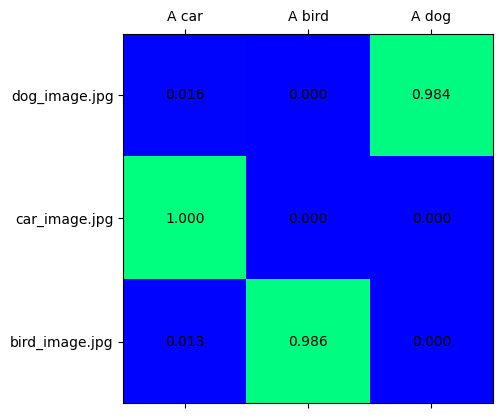

In [11]:
text_vision_scores = softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.TEXT].T, axis=-1)

visualize_prob_matrix(text_vision_scores, text_list, image_list)

### Text-Audio classification
[back to top ⬆️](#Table-of-contents:)


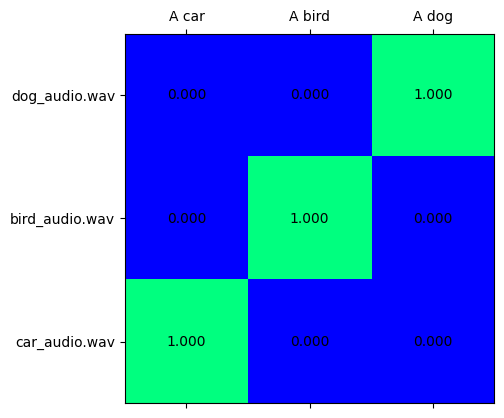

In [12]:
text_audio_scores = softmax(embeddings[ModalityType.AUDIO] @ embeddings[ModalityType.TEXT].T, axis=-1)

visualize_prob_matrix(text_audio_scores, text_list, audio_list)

### Image-Audio classification
[back to top ⬆️](#Table-of-contents:)


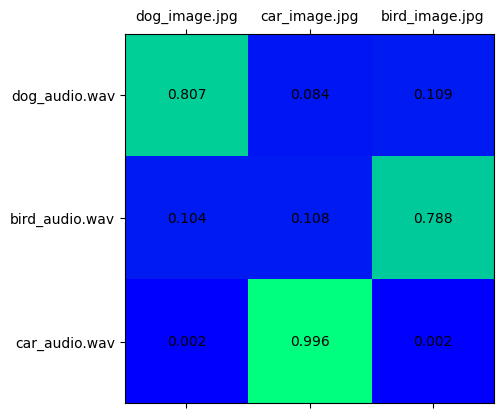

In [13]:
audio_vision_scores = softmax(embeddings[ModalityType.VISION] @ embeddings[ModalityType.AUDIO].T, axis=-1)

visualize_prob_matrix(audio_vision_scores, image_list, audio_list)

Putting all together, we can match text, image, and sound for our data.

Predicted label: A car 
probability for image - 1.000
probability for audio - 1.000


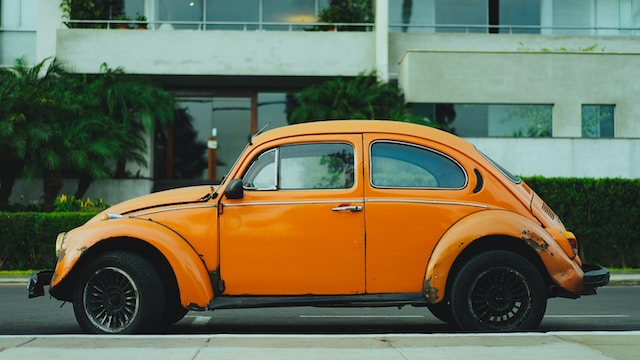

In [14]:
import IPython.display as ipd
from PIL import Image
text_image_ids = np.argmax(text_vision_scores, axis=0)
text_audio_ids = np.argmax(text_audio_scores, axis=0)
print(f"Predicted label: {text_list[0]} \nprobability for image - {text_vision_scores[text_image_ids[0], 0]:.3f}\nprobability for audio - {text_audio_scores[0, text_audio_ids[0]]:.3f}")
display(Image.open(image_paths[text_image_ids[0]]))
ipd.Audio(audio_paths[text_audio_ids[0]])

Predicted label: A bird 
probability for image - 0.986
probability for audio - 1.000


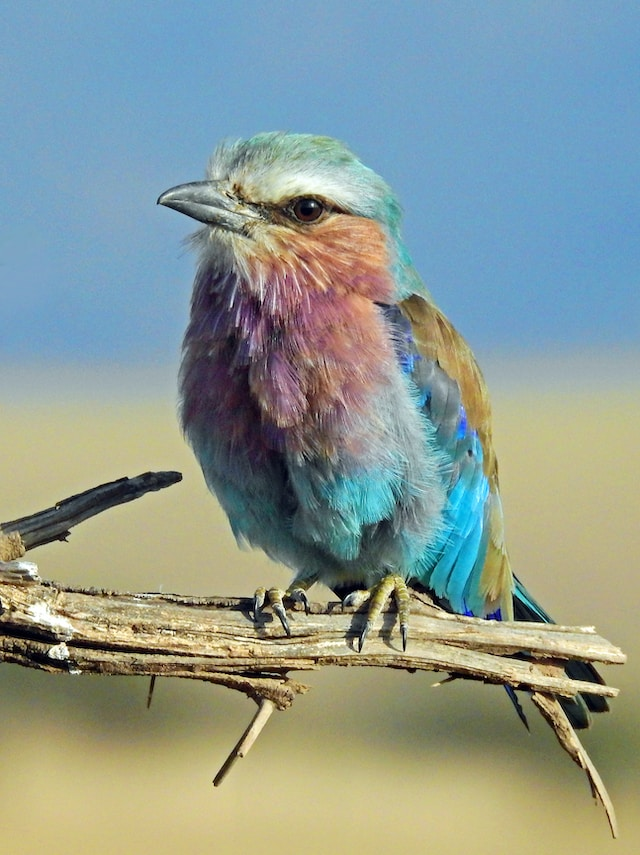

In [15]:
print(f"Predicted label: {text_list[1]} \nprobability for image - {text_vision_scores[text_image_ids[1], 1]:.3f}\nprobability for audio - {text_audio_scores[1, text_audio_ids[1]]:.3f}")
display(Image.open(image_paths[text_image_ids[1]]))
ipd.Audio(audio_paths[text_audio_ids[1]])

Predicted label: A dog 
probability for image - 0.984
probability for audio - 1.000


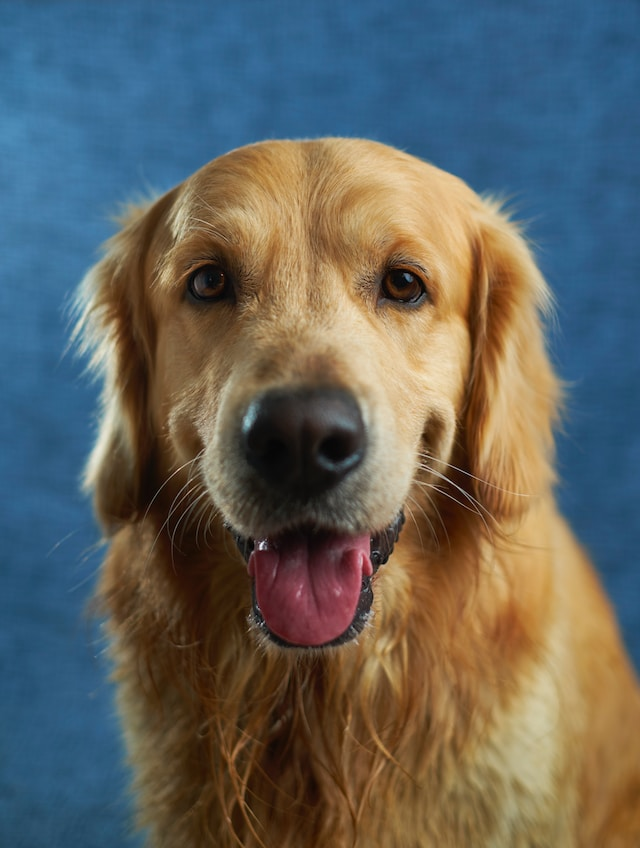

In [16]:
print(f"Predicted label: {text_list[2]} \nprobability for image - {text_vision_scores[text_image_ids[2], 2]:.3f}\nprobability for audio - {text_audio_scores[2, text_audio_ids[2]]:.3f}")
display(Image.open(image_paths[text_image_ids[2]]))
ipd.Audio(audio_paths[text_audio_ids[2]])

## Next Steps
[back to top ⬆️](#Table-of-contents:)

Open the [239-image-bind-quantize](239-image-bind-quantize.ipynb) notebook to quantize the IR model with the Post-training Quantization API of NNCF and compare `FP16` and `INT8` models.